## Pre-Processing

### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import pickle

### Load the Data

In [5]:
df = pd.read_csv('sales_cleaned.csv', index_col='Order Date', parse_dates=True).sort_index()

In [6]:
df.shape

(9800, 11)

In [7]:
df.head()

,Segment,Region,Category,Year,Month,Day,Weekday,Week,Quarter,Is Weekend,Sales
Order Date,,,,,,,,,,,
2015-01-03,Consumer,Central,Office Supplies,2015,1,3,5,1,1,1,16.448
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,3.540
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,272.736
2015-01-04,Home Office,Central,Office Supplies,2015,1,4,6,1,1,1,11.784
2015-01-05,Consumer,East,Office Supplies,2015,1,5,0,2,1,0,19.536


### Tests for Autocorrelation and Stationarity (to be moved to EDA)

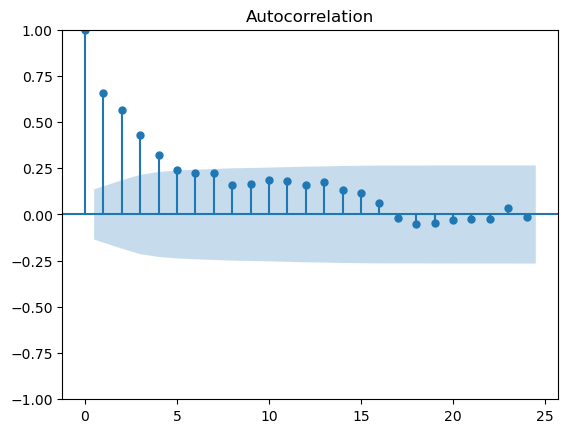

In [9]:
df_resampled = df['Sales'].resample('W').sum()
plot_acf(df_resampled.dropna())
plt.show()

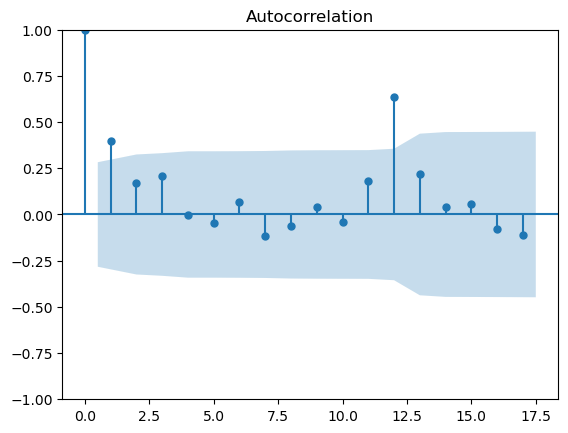

In [10]:
df_resampled = df['Sales'].resample('ME').sum()
plot_acf(df_resampled.dropna())
plt.show()

We can see that lags 1-5 show significant autocorrelation for weekly resampled data, whereas lags 1 and 12 are significant for monthly resampling.  
We will focus on monthly trends and seasonality, but it is good to know we can explore weekly trends should there be a desire for a finer granularity.

In [12]:
# Perform the ADF test
result = adfuller(df_resampled)

# Output the test statistic and p-value
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -4.0139390207584915
p-value: 0.0013392557080076503


With a p-value of 0.001, the Augmented Dickey-Fuller test results indicate our monthly resample data is stationary.

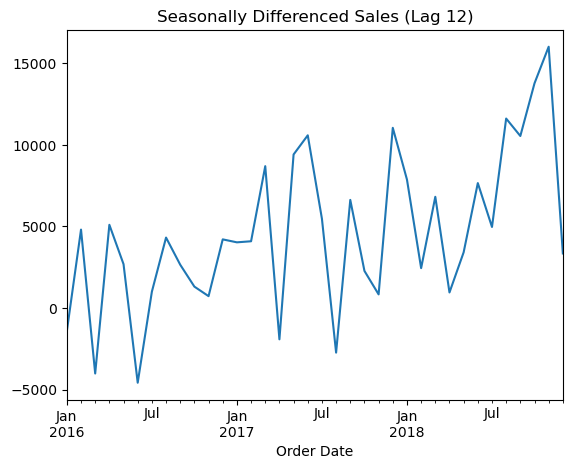

ADF Statistic (Seasonal Differenced): -4.651064282273594
p-value: 0.00010389044229710069


In [14]:
# Seasonal differencing
df_seasonal_diff = df_resampled - df_resampled.shift(12)
df_seasonal_diff = df_seasonal_diff.dropna()

df_seasonal_diff.plot(title="Seasonally Differenced Sales (Lag 12)")
plt.show()

result = adfuller(df_seasonal_diff)

print("ADF Statistic (Seasonal Differenced):", result[0])
print("p-value:", result[1])

The seasonally differenced data is also stationary.

### Resampling & One-Hot Encoding

Creating a custom function to handle the delicate process of resampling the data can be helpful for preparing data for different models. We must separate and aggregate column types individually to avoid illogical sums or concatenations of strings when resampling. We will also create dummy variables for categorical features, ensure all encoded columns exist (important for neural nets), and convert all boolean values to integers. Finally, we merge the results back together.

In [18]:
def preprocess(df, resample_data=True, freq='ME', drop_first=True):
    df = df.copy()
    
    # Columns
    metric_cols = ['Sales']
    cat_cols = ['Category']
    time_cols = ['Year', 'Month', 'Day', 'Weekday', 'Week', 'Quarter', 'Is Weekend']

    # Optional resampling for SARIMA/SARIMAX
    if resample_data:
        # Prepare expected dummy columns before resampling
        expected_dummies = pd.get_dummies(df[cat_cols], drop_first=drop_first).columns.tolist()

        # Custom mode aggregation
        def mode_agg(x):
            mode_val = x.mode()
            return mode_val[0] if not mode_val.empty else np.nan

        agg_dict = {
            **{col: 'sum' for col in metric_cols},
            **{col: mode_agg for col in time_cols + cat_cols}
        }

        df = df[metric_cols + time_cols + cat_cols].resample(freq).agg(agg_dict)

    # One-hot encode categorical variables
    df = pd.get_dummies(df, columns=cat_cols, drop_first=drop_first)

    # Fill missing dummies from resample (if any)
    if resample_data:
        for col in expected_dummies:
            if col not in df.columns:
                df[col] = 0

    # Convert booleans to integers
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)

    return df


### Model-Specific Prep

#### SARIMA

In [21]:
# Only Sales for SARIMA
df_sarima = preprocess(df)['Sales']

In [22]:
df_sarima

Order Date
2015-01-31     9912.7315
2015-02-28     3764.3125
2015-03-31    21980.1340
2015-04-30    18542.3085
2015-05-31    16460.4170
2015-06-30    20751.6071
2015-07-31    20371.5965
2015-08-31    20172.5380
2015-09-30    37564.4618
2015-10-31    21706.3450
2015-11-30    48747.4302
2015-12-31    40913.8830
2016-01-31     8490.7590
2016-02-29     8568.0125
2016-03-31    17962.2920
2016-04-30    23640.7010
2016-05-31    19146.1465
2016-06-30    16168.9850
2016-07-31    21369.5795
2016-08-31    24488.1942
2016-09-30    40216.1980
2016-10-31    23014.5500
2016-11-30    49471.7103
2016-12-31    45118.6860
2017-01-31    12514.0810
2017-02-28    12656.7335
2017-03-31    26654.6775
2017-04-30    21717.9490
2017-05-31    28555.6425
2017-06-30    26753.0510
2017-07-31    26835.9235
2017-08-31    21750.2563
2017-09-30    46840.1585
2017-10-31    25285.3030
2017-11-30    50303.7435
2017-12-31    56162.6780
2018-01-31    20385.8515
2018-02-28    15096.6884
2018-03-31    33470.2723
2018-04-30    

#### SARIMAX

In [24]:
df_sarimax = preprocess(df)

# Add cyclical encoding for time variables with SARIMAX
df_sarimax['Month_sin'] = np.sin(2 * np.pi * df_sarimax['Month'] / 12)
df_sarimax['Month_cos'] = np.cos(2 * np.pi * df_sarimax['Month'] / 12)

df_sarimax['Weekday_sin'] = np.sin(2 * np.pi * df_sarimax['Weekday'] / 7)
df_sarimax['Weekday_cos'] = np.cos(2 * np.pi * df_sarimax['Weekday'] / 7)

# Create lags and rolling stats
df_sarimax['Lag_1'] = df_sarimax['Sales'].shift(1)
df_sarimax['Lag_12'] = df_sarimax['Sales'].shift(12)
df_sarimax['Rolling_Mean_3'] = df_sarimax['Sales'].rolling(window=3).mean()
df_sarimax['Rolling_Std_3'] = df_sarimax['Sales'].rolling(window=3).std()
df_sarimax['Rolling_Mean_12'] = df_sarimax['Sales'].rolling(window=12).mean()
df_sarimax['Rolling_Std_12'] = df_sarimax['Sales'].rolling(window=12).std()
df_sarimax.dropna(inplace=True)

In [25]:
# Drop features already captured or unnecessary
df_sarimax.drop(columns=['Month', 'Weekday', 'Day', 'Week', 'Quarter', 'Year', 'Is Weekend'], inplace=True)

In [26]:
df_sarimax

,Sales,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos,Lag_1,Lag_12,Rolling_Mean_3,Rolling_Std_3,Rolling_Mean_12,Rolling_Std_12
Order Date,,,,,,,,,,,,,
2016-01-31,8490.7590,0,0,5.000000e-01,8.660254e-01,-0.974928,-0.222521,40913.8830,9912.7315,32717.357400,21343.316705,23288.816050,13006.288099
2016-02-29,8568.0125,0,0,8.660254e-01,5.000000e-01,-0.974928,-0.222521,8490.7590,3764.3125,19324.218167,18697.238105,23689.124383,12411.035003
2016-03-31,17962.2920,0,0,1.000000e+00,6.123234e-17,0.781831,0.623490,8568.0125,21980.1340,11673.687833,5446.227942,23354.304217,12515.090509
2016-04-30,23640.7010,0,0,8.660254e-01,-5.000000e-01,0.000000,1.000000,17962.2920,18542.3085,16723.668500,7612.300952,23779.170258,12423.083285
2016-05-31,19146.1465,0,0,5.000000e-01,-8.660254e-01,0.781831,0.623490,23640.7010,16460.4170,20249.713167,2995.743102,24002.981050,12302.854975
2016-06-30,16168.9850,0,0,1.224647e-16,-1.000000e+00,-0.974928,-0.222521,19146.1465,20751.6071,19651.944167,3761.450313,23621.095875,12482.761466
2016-07-31,21369.5795,0,0,-5.000000e-01,-8.660254e-01,-0.974928,-0.222521,16168.9850,20371.5965,18894.903667,2609.384604,23704.261125,12462.451803
2016-08-31,24488.1942,0,0,-8.660254e-01,-5.000000e-01,0.781831,0.623490,21369.5795,20172.5380,20675.586233,4202.800307,24063.899142,12413.442725
2016-09-30,40216.1980,0,0,-1.000000e+00,-1.836970e-16,-0.974928,-0.222521,24488.1942,37564.4618,28691.323900,10101.904854,24284.877158,12696.007798


#### LSTM

While regression or cluster models require dropping the first dummy variable, we must specify to keep all dummy variables by setting the drop parameter of our custom function to False for LSTM.

In [72]:
df_lstm = preprocess(df, resample_data=False, drop_first=False)

# Add cyclical encodings
df_lstm['Month_sin'] = np.sin(2 * np.pi * df_lstm['Month'] / 12)
df_lstm['Month_cos'] = np.cos(2 * np.pi * df_lstm['Month'] / 12)
df_lstm['Weekday_sin'] = np.sin(2 * np.pi * df_lstm['Weekday'] / 7)
df_lstm['Weekday_cos'] = np.cos(2 * np.pi * df_lstm['Weekday'] / 7)

# Drop raw data
df_lstm.drop(columns=['Segment', 'Region', 'Month', 'Day', 'Weekday', 'Week', 'Quarter'], inplace=True)

In [74]:
df_lstm

,Year,Is Weekend,Sales,Category_Furniture,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos
Order Date,,,,,,,,,,
2015-01-03,2015,1,16.448,0,1,0,5.000000e-01,0.866025,-0.974928,-0.222521
2015-01-04,2015,1,3.540,0,1,0,5.000000e-01,0.866025,-0.781831,0.623490
2015-01-04,2015,1,272.736,0,1,0,5.000000e-01,0.866025,-0.781831,0.623490
2015-01-04,2015,1,11.784,0,1,0,5.000000e-01,0.866025,-0.781831,0.623490
2015-01-05,2015,0,19.536,0,1,0,5.000000e-01,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2018-12-30,2018,1,20.720,0,1,0,-2.449294e-16,1.000000,-0.781831,0.623490
2018-12-30,2018,1,323.136,1,0,0,-2.449294e-16,1.000000,-0.781831,0.623490
2018-12-30,2018,1,209.300,0,1,0,-2.449294e-16,1.000000,-0.781831,0.623490


Different time series models have different input needs. SARIMA/SARIMAX do not need scaling, but it is important for LSTM. 

In [32]:
scaler = MinMaxScaler()
features = df_lstm.drop(columns=['Sales']).columns
df_lstm[features] = scaler.fit_transform(df_lstm[features])

In [76]:
scaler = MinMaxScaler()
df_lstm = pd.DataFrame(
    scaler.fit_transform(df_lstm),
    columns=df_lstm.columns,
    index=df_lstm.index
)

In [78]:
df_lstm

,Year,Is Weekend,Sales,Category_Furniture,Category_Office Supplies,Category_Technology,Month_sin,Month_cos,Weekday_sin,Weekday_cos
Order Date,,,,,,,,,,
2015-01-03,0.0,1.0,0.031995,0.0,1.0,0.0,0.75,0.933013,0.000000,0.356896
2015-01-04,0.0,1.0,0.006190,0.0,1.0,0.0,0.75,0.933013,0.099031,0.801938
2015-01-04,0.0,1.0,0.544370,0.0,1.0,0.0,0.75,0.933013,0.099031,0.801938
2015-01-04,0.0,1.0,0.022671,0.0,1.0,0.0,0.75,0.933013,0.099031,0.801938
2015-01-05,0.0,0.0,0.038169,0.0,1.0,0.0,0.75,0.933013,0.500000,1.000000
...,...,...,...,...,...,...,...,...,...,...
2018-12-30,1.0,1.0,0.040536,0.0,1.0,0.0,0.50,1.000000,0.099031,0.801938
2018-12-30,1.0,1.0,0.645130,1.0,0.0,0.0,0.50,1.000000,0.099031,0.801938
2018-12-30,1.0,1.0,0.417548,0.0,1.0,0.0,0.50,1.000000,0.099031,0.801938


### Training/Test Split

SARIMA does not use features other than the target feature and time. SARIMAX utilizes lag features and rolling stats, which reduces the total number of rows. While including those features would be beneficial to LSTM, I have opted to not include them due to limited data availability. These nuances create a new problem - each df contains a different number of observations.

Ultimately, we want to see which model performs the best and we would ideally have have an 80/20 split for training/test sets across all models. Given that lag 12 is significant in this data, LSTM requires a sequence size of 12; LSTM then needs t+1 observations (months here) to make a single prediction. To have anything meaningful, we need at least 6 predictions which would require 18 months of data for the test set, leaving 30 months for training. This creates a 60/40 split which can be fine for LSTM, though not ideal.

SARIMA and SARIMAX, on the other hand, need larger training sets to perform well. Given data constraints, each model will receive optimal training/test splits tailored to that model.

In [80]:
# Unified 80/20 split for all models
train_size_sarima = int(len(df_sarima) * 0.8)
train_size_sarimax = int(len(df_sarimax) * 0.8)
train_size_lstm = int(len(df_lstm) * 0.8)

# Define training and test sets for each model
dfs = {
    'sarima': df_sarima.iloc[train_size_sarima:],     # Test set: last 20%
    'sarimax': df_sarimax.iloc[train_size_sarimax:],  # Test set: last 20%
    'lstm': df_lstm.iloc[train_size_lstm:]            # Test set: last 20%
}

train_dfs = {
    'sarima': df_sarima.iloc[:train_size_sarima],     # Train set: first 80%
    'sarimax': df_sarimax.iloc[:train_size_sarimax],  # Train set: first 80%
    'lstm': df_lstm.iloc[:train_size_lstm]            # Train set: first 80%
}

# Verify split sizes
print(f"SARIMA train size: {len(train_dfs['sarima'])}, SARIMA test size: {len(dfs['sarima'])}")
print(f"SARIMAX train size: {len(train_dfs['sarimax'])}, SARIMAX test size: {len(dfs['sarimax'])}")
print(f"LSTM train size: {len(train_dfs['lstm'])}, LSTM test size: {len(dfs['lstm'])}")

SARIMA train size: 38, SARIMA test size: 10
SARIMAX train size: 28, SARIMAX test size: 8
LSTM train size: 7840, LSTM test size: 1960


In [82]:
with open('pre-processed_data.pkl', 'wb') as f:
    pickle.dump({
        'df': df,
        'df_sarima': df_sarima,
        'df_sarimax': df_sarimax,
        'df_lstm': df_lstm,
        'sarima_train': train_dfs['sarima'],
        'sarima_test': dfs['sarima'],
        'sarimax_train': train_dfs['sarimax'],
        'sarimax_test': dfs['sarimax'],
        'lstm_train': train_dfs['lstm'],
        'lstm_test': dfs['lstm']
    }, f)